In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchmetrics import MeanAbsolutePercentageError


from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config

from models.predictor import GRU
from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel

import copy

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_diff2.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Diffusion_TS Model
diffusion_ts = instantiate_from_config(configs['model']).to(device)
batch_size = 128

In [3]:
# dataloader
dl_info = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dl_info_test["dataloader"]
dl_info_test["dataset"]

dataset = dl_info['dataset']

In [4]:
dl = dl_info["dataloader"]

In [5]:
diffusion_ts.load_state_dict(torch.load("check_points/stock/diff_24/model_notdiff_10000.pth"))


In [6]:
# trainer = Trainer(config_solver=configs["solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
# trainer.train_decomp("model_notdiff")

  0%|          | 0/10000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
combiend_loss: 0.048407 l1_loss : 0.583465 fourier_loss : 0.000000: 100%|██████████| 10000/10000 [14:36<00:00, 11.40it/s]


In [7]:
# generate adversarial data
fake_data = diffusion_ts.generate_mts(batch_size=1500)


reverse step from x_T to x_0:   0%|          | 0/100 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


In [8]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
gt_data = np.load(os.path.join(dataset.dir, f"stock_origin_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(gt_data))[:1500]
ori_data = gt_data[idx]

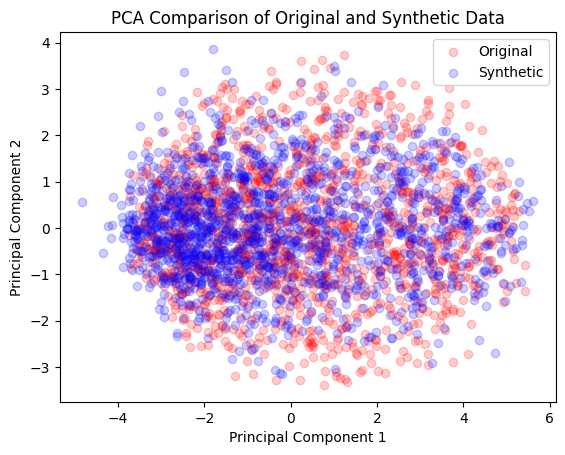

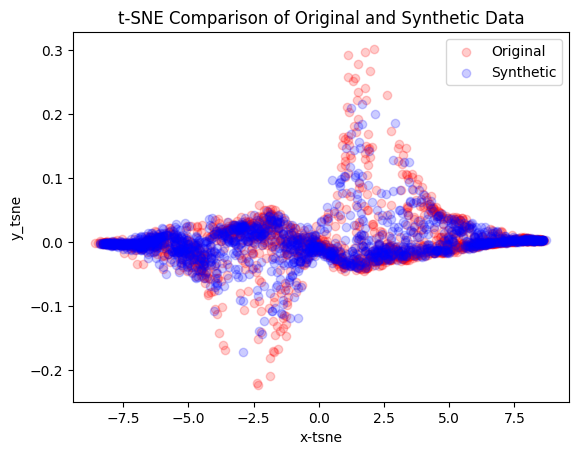

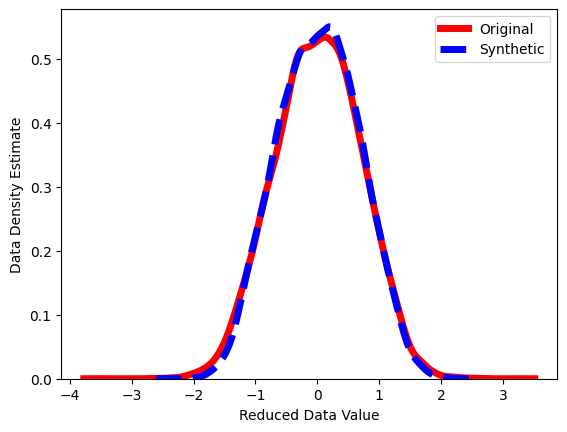

In [9]:
visualize_pca(ori_data, fake_data, 1500)
visualize_tsne(ori_data, fake_data, 1500)
visualize_kernel(ori_data, fake_data, 1500)

In [10]:
test_data_norm_origin = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_std_{seq_length}_test.npy"))).to(device)

test_dataset = TensorDataset(test_data_norm_origin, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()


In [11]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:,:-1,:].float().to(device)
                y_train = data[:,-1:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [12]:
def evaluate_model(model, dataloader):
    model.eval()
    # define loss for comparison
    l1loss = nn.L1Loss()
    l2loss = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    
    total_l1 = 0
    total_l2 = 0
    total_mape = 0

    predictions, true_vals = [], []
    with torch.no_grad():
        for data_norm, data_mean, data_std  in dataloader:
            x_test = data_norm[:, :(seq_length - 1), :].float().to(device)
            y_test = data_norm[:, (seq_length - 1):, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            
            y_pred_unnorm = y_pred * data_std[:, :, :1] + data_mean[:, :, :1]
            y_test_unnorm = y_test * data_std[:, :, :1] + data_mean[:, :, :1]
            total_l1 += l1loss(y_pred_unnorm, y_test_unnorm) * len(data_norm)
            total_l2 += l2loss(y_pred_unnorm, y_test_unnorm) * len(data_norm)
            # total_mape += mapeloss(y_pred_unnorm, y_test_unnorm).item() * len(data_norm)

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    n_data = len(dataloader.dataset)
    total_l1 /= n_data
    total_l2 /= n_data
    # total_mape /= n_data
    
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_l1, total_l2, mape_loss, predictions, true_vals

In [13]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)

train_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, num_epochs=3000)


 loss: 0.064329:  11%|█         | 325/3000 [00:07<01:03, 42.02it/s]


KeyboardInterrupt: 

In [ ]:
train_data_norm_origin = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_data_{seq_length}_train.npy"))).to(device)
train_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_mean_{seq_length}_train.npy"))).to(device)
train_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_std_{seq_length}_train.npy"))).to(device)

train_dataset = TensorDataset(train_data_norm_origin, train_mean, train_std)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()


In [ ]:
l1, l2, mape, pre_y, true_y = evaluate_model(gt_predictor, train_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


In [ ]:
plt.plot(pre_y[-50:])
plt.plot(true_y[-50:])

In [ ]:
l1, l2, mape, pre_y, true_y = evaluate_model(gt_predictor, test_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


In [ ]:
plt.plot(pre_y[-50:], marker="o")
plt.plot(true_y[-50:], marker="o")

In [ ]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)

train_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, num_epochs=3000)
l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, train_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


In [ ]:
for _ in range(10):
    fake_data = diffusion_ts.generate_mts(batch_size=3000)
    syn_dl = DataLoader(fake_data, batch_size=batch_size, shuffle=True)
    train_model(gt_predictor, syn_dl,lossfn, gt_optimizer, 5000)
    l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, test_loader)
    print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")



Adv_synthetic : L1 loss: 1.44225 	 L2 Loss : 5.67844 	 MAPE loss : 0.01747 